
# **LetsGrowMore- Virtual Internship Program (VIP)- Data Science**

**Beginner Level Task**

Name:- **Ramkrishna Allampallewar**

Task 3 :- Music Recommendation

**Import the required libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings('ignore')

**Load the data**

In [ ]:
song_data = pd.read_csv('/content/songs.csv')

In [ ]:
song_data.head()

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


In [ ]:
user_data = pd.read_csv('/content/users.csv')

In [ ]:
user_data.head()

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


**Pre-process the data**

In [ ]:
song_data["year"] = song_data["year"].astype('Int64')

In [ ]:
song_data.rename(columns={"song_id":"SongId","title":"Title","release":"Album","artist_name":"Artist","year":"Year"},inplace=True)

In [ ]:
user_data["listen_count"] = user_data["listen_count"].astype('Int64')

In [ ]:
user_data.rename(columns={"user_id":"UserId","song_id":"SongId","listen_count":"ListenCount"},inplace=True)

**Merge the datasets**

In [ ]:
final_data = pd.merge(user_data, song_data.drop_duplicates(["SongId"]), on='SongId', how='left')
final_data['Song'] = final_data['Title'] + ' by ' + final_data['Artist']
final_data = final_data.drop(['Title'],axis=1)
final_data = final_data.head(50000)
final_data.head()

,UserId,SongId,ListenCount,Album,Artist,Year,Song
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,Thicker Than Water,Jack Johnson,0,The Cove by Jack Johnson
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Flamenco Para Niños,Paco De Lucia,1976,Entre Dos Aguas by Paco De Lucia
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Graduation,Kanye West,2007,Stronger by Kanye West
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,In Between Dreams,Jack Johnson,2005,Constellations by Jack Johnson
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,There Is Nothing Left To Lose,Foo Fighters,1999,Learn To Fly by Foo Fighters


**Visualize the data**

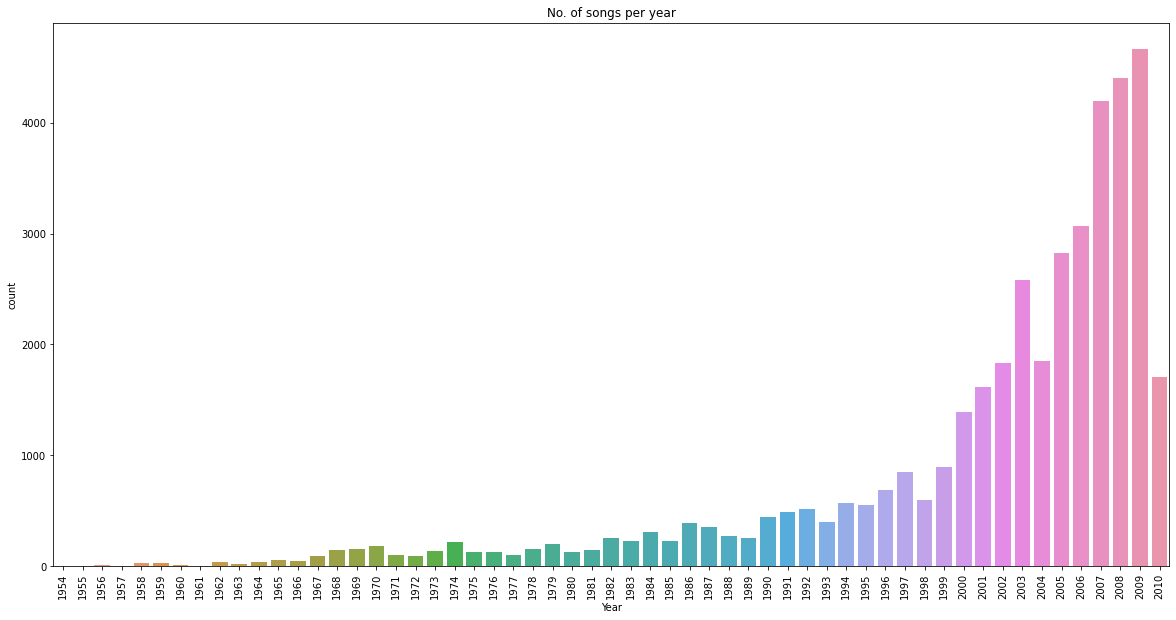

In [ ]:
#Using countplot to see the number of songs per year
plt.figure(figsize=(20,10))
sns.countplot(x='Year', data=final_data[-(final_data['Year']==0)])
plt.xticks(rotation=90)
plt.title("No. of songs per year")
plt.show()

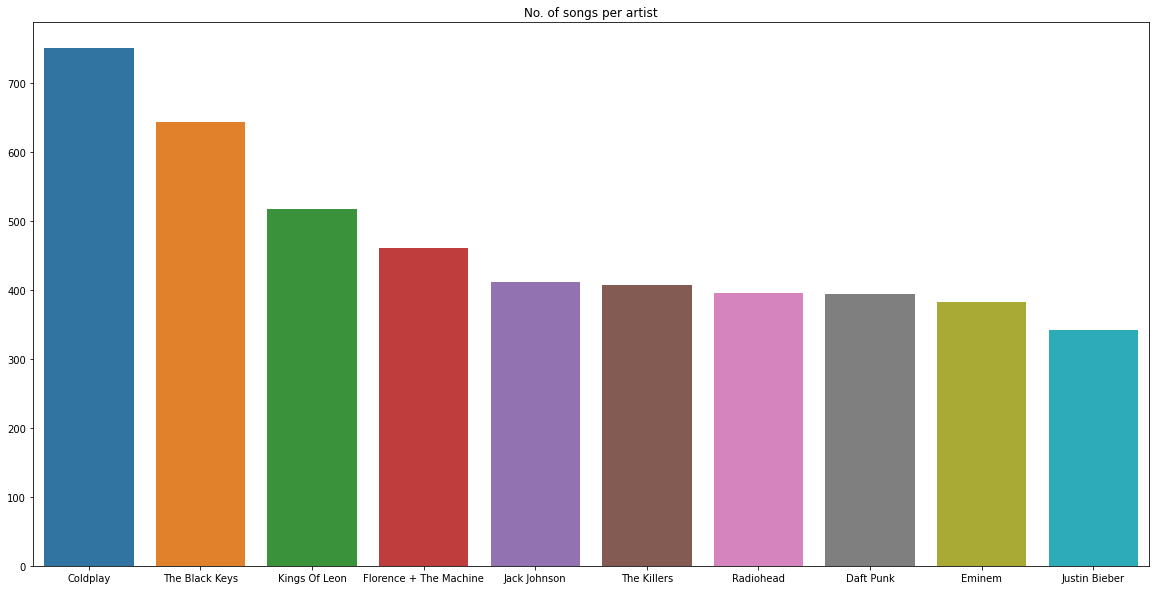

In [ ]:
#Using barplot to see the number of songs per artist
plt.figure(figsize=(20,10))
sns.barplot(final_data['Artist'].value_counts()[:10].index,final_data['Artist'].value_counts()[:10].values)
plt.title("No. of songs per artist")
plt.show()

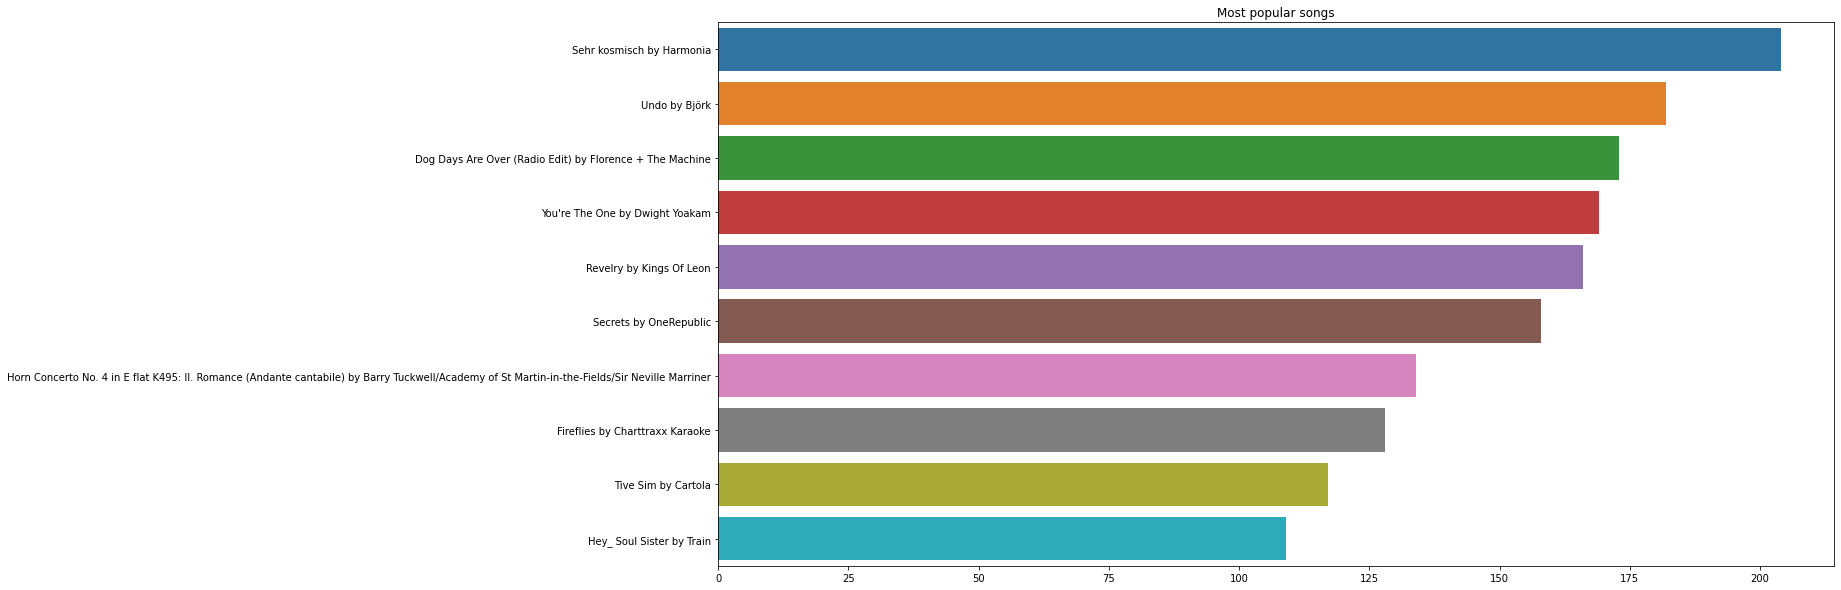

In [ ]:
#Using barplot to see the most popular songs
plt.figure(figsize=(20,10))
sns.barplot(final_data['Song'].value_counts()[:10].values,final_data['Song'].value_counts()[:10].index)
plt.title("Most popular songs")
plt.show()

**Build the recommendation system**

In [ ]:
class Recommendation():
    def __init__(self, data, user_id, song):
        self.data = data
        self.user_id = user_id
        self.song = song
        self.glcm = None
        
    def song_history(self, user):
        user_data = self.data[self.data[self.user_id] == user]
        return list(user_data[self.song].unique())
        
    def users(self, item):
        item_data = self.data[self.data[self.song] == item]
        return set(item_data[self.user_id].unique())
        
    def all_songs(self):
        return list(self.data[self.song].unique())
        
    def get_glcm(self, user_songs, all_songs):
        users = []        
        for p in range(0, len(user_songs)):
            users.append(self.users(user_songs[p]))   
        glcm = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)

        for p in range(0,len(all_songs)):
            songs_p_data = self.data[self.data[self.song] == all_songs[p]]
            users_p = set(songs_p_data[self.user_id].unique())
            
            for q in range(0,len(user_songs)):           
                users_q = users[q]
                users_intersection = users_p.intersection(users_q)
               
                users_union = users_p.union(users_q)
                glcm[q,p] = float(len(users_intersection))/float(len(users_union))

        return glcm

    def generate(self, user, glcm, all_songs, user_songs):
        scores = glcm.sum(axis=0)/float(glcm.shape[0])
        scores = np.array(scores)[0].tolist()
        sort_index = sorted(((e,p) for p,e in enumerate(list(scores))), reverse=True)
        columns = ['UserID', 'Song', 'Score', 'Rank']
        final_data = pd.DataFrame(columns=columns)
         
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 10:
                final_data.loc[len(final_data)]=[user,all_songs[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        print("Music Recommendations: \n")
        return final_data.drop(['UserID'], axis=1)

    def get_recommendations(self, user):
        user_songs = self.song_history(user)    
        all_songs = self.all_songs()
        glcm = self.get_glcm(user_songs, all_songs)
        return self.generate(user, glcm, all_songs, user_songs)

    def get_similar_songs(self, item_list):
        user_songs = item_list
        all_songs = self.all_songs()
        glcm = self.get_glcm(user_songs, all_songs)
        return self.generate("", glcm, all_songs, user_songs)

**Get song history for a user**

In [ ]:
r = Recommendation(final_data,'UserId','Song')
history=r.song_history(final_data['UserId'][6])

In [ ]:
print("Song history of the user:\n")
for song in history:
  print(song)

Song history of the user:

The Cove by Jack Johnson
Entre Dos Aguas by Paco De Lucia
Stronger by Kanye West
Constellations by Jack Johnson
Learn To Fly by Foo Fighters
Apuesta Por El Rock 'N' Roll by Héroes del Silencio
Paper Gangsta by Lady GaGa
Stacked Actors by Foo Fighters
Sehr kosmisch by Harmonia
Heaven's gonna burn your eyes by Thievery Corporation feat. Emiliana Torrini
Let It Be Sung by Jack Johnson / Matt Costa / Zach Gill / Dan Lebowitz / Steve Adams
I'll Be Missing You (Featuring Faith Evans & 112)(Album Version) by Puff Daddy
Love Shack by The B-52's
Clarity by John Mayer
I?'m A Steady Rollin? Man by Robert Johnson
The Old Saloon by The Lonely Island
Behind The Sea [Live In Chicago] by Panic At The Disco
Champion by Kanye West
Breakout by Foo Fighters
Ragged Wood by Fleet Foxes
Mykonos by Fleet Foxes
Country Road by Jack Johnson / Paula Fuga
Oh No by Andrew Bird
Love Song For No One by John Mayer
Jewels And Gold by Angus & Julia Stone
Warning by Incubus
83 by John Mayer
Ne

**Get recommendations**

In [ ]:
r.get_recommendations(final_data['UserId'][6])

Music Recommendations: 



,Song,Score,Rank
0,Questions by Jack Johnson,0.037157,1
1,Great Indoors by John Mayer,0.036953,2
2,Wrong Turn by Jack Johnson,0.036740,3
3,Ghost Dream by Hymie's Basement,0.036463,4
4,Baby I Want You by Amos Lee,0.036244,5
5,Better That We Break by Maroon 5,0.035016,6
6,The Sharing Song by Jack Johnson,0.034193,7
7,Better Days by Amos Lee,0.034193,8
8,Dreamin' by Amos Lee,0.034193,9
9,Mr.Curiosity (Album Version) by Jason Mraz,0.034193,10


In [ ]:
r.get_similar_songs(['The Cove by Jack Johnson'])

Music Recommendations: 



,Song,Score,Rank
0,Moonshine by Jack Johnson,0.400000,1
1,Baby I Want You by Amos Lee,0.333333,2
2,Country Road by Jack Johnson / Paula Fuga,0.333333,3
3,Questions by Jack Johnson,0.285714,4
4,Wrong Turn by Jack Johnson,0.285714,5
5,Holes To Heaven by Jack Johnson,0.266667,6
6,What's Been Going On by Amos Lee,0.250000,7
7,Ghost Dream by Hymie's Basement,0.250000,8
8,Painting by Chagall by The Weepies,0.250000,9
9,Mrs Thompson by The Kooks,0.250000,10
